## Train sea lion classifier with a convnet

In [12]:
INPUT_DIR = '../../input/kaggle-sea-lion/02/'
OUTPUT_DIR = '../../output/kaggle-sea-lion/05/'
#IMAGE_DIMS = (148,148,3)
IMAGE_DIMS = (84,84,3)
#IMAGE_DIMS = (32,32,3)

INPUT_DATASET_NAME = 'lion-patches-0px'
SAVE_WEIGHTS_FILE = OUTPUT_DIR + 'last-weights.h5'
SAVE_MODEL_FILE = OUTPUT_DIR + 'last-model.yml'
LOAD_WEIGHTS_FILE = None#OUTPUT_DIR + 'weights-0.72-simple.h5'
LOAD_MODEL_FILE = None

RECREATE_OUTPUT_DIR = False
RUN_TRAINING = True

OUTPUT_WEIGHT = (1,1,1,1,1,1)
TRAIN_EPOCHS = 3
INPUT_RANGE = 1

BATCH_SIZE=64

In [13]:
%matplotlib inline
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import sklearn
import os
import glob

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import models

from modules.logging import logger
import modules.utils as utils
from modules.utils import Timer
import modules.logging
import modules.cnn as cnn
import modules.lions as lions

## Prepare

### Prepare output dir

In [3]:
utils.mkdirs(OUTPUT_DIR, dirs=['tf-logs','weights'], recreate=RECREATE_OUTPUT_DIR)
modules.logging.setup_file_logger(OUTPUT_DIR + 'out.log')
TF_LOGS_DIR = OUTPUT_DIR + 'tf-logs/'
WEIGHTS_DIR = OUTPUT_DIR + 'weights/'
input_dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)

logger.info('Output dirs created')

2017-04-23 20:06:55,474 INFO Output dirs created


### Prepare train, validate and test data flows

In [5]:
logger.info('Using dataset ' + input_dataset_path + ' as input')
h5file = h5py.File(input_dataset_path, 'r')

#used for image augmentation (creating new images for balancing)
image_augmentation_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=359,
        width_shift_range=0,
        height_shift_range=0,
        horizontal_flip=True,
        vertical_flip=True)

#applied to all images during training
image_randomize_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=True,
        featurewise_std_normalization=False,
        samplewise_std_normalization=True,
        zca_whitening=False,
        rotation_range=359,
        width_shift_range=6,
        height_shift_range=6,
        horizontal_flip=True,
        vertical_flip=True)

logger.info('preparing train data')
train_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=INPUT_RANGE)
train_balance_generator = utils.ClassBalancerGeneratorXY(train_batch_generator,
                                                         image_augmentation=image_augmentation_generator,
                                                         output_weight=OUTPUT_WEIGHT,
                                                         max_augmentation_ratio=5,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         start_ratio=0, end_ratio=0.7)
train_generator = utils.image_augmentation_xy(train_balance_generator.flow(), image_randomize_generator)
logger.info('train size=' + str(train_balance_generator.size) + ' batches=' + str(train_balance_generator.nr_batches))


logger.info('preparing valid data')
valid_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=INPUT_RANGE)
valid_balance_generator = utils.ClassBalancerGeneratorXY(valid_batch_generator,
                                                         image_augmentation=image_augmentation_generator,
                                                         output_weight=OUTPUT_WEIGHT,
                                                         max_augmentation_ratio=5,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         start_ratio=0.7, end_ratio=0.85)
logger.info('valid size=' + str(valid_balance_generator.size) + ' batches=' + str(valid_balance_generator.nr_batches))



logger.info('preparing test data')
test_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=INPUT_RANGE)
test_balance_generator = utils.ClassBalancerGeneratorXY(test_batch_generator,
                                                         image_augmentation=image_augmentation_generator,
                                                         output_weight=OUTPUT_WEIGHT,
                                                         max_augmentation_ratio=5,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         start_ratio=0.85, end_ratio=1)
logger.info('test size=' + str(test_balance_generator.size) + ' batches=' + str(test_balance_generator.nr_batches))

#FIXME when using 1 on end ratio size and nr_batches gets negative (h5 batch generator, not balancer...)

2017-04-23 20:06:55,626 INFO Using dataset ../../input/kaggle-sea-lion/02/lion-patches-0px-84-84.h5 as input
2017-04-23 20:06:55,628 INFO preparing train data
2017-04-23 20:06:55,629 INFO loading input data for class distribution analysis...
2017-04-23 20:06:55,630 INFO loading Y from raw dataset
2017-04-23 20:06:55,631 INFO > [started] generator dump...


135062/135062

2017-04-23 20:07:35,899 INFO > [done]    generator dump (40267.976 ms)
2017-04-23 20:07:35,900 INFO saving Y to temp file ../../output/kaggle-sea-lion/05/class-balancer-5-1-(1, 1, 1, 1, 1, 1)-False-0-0.7.npy
2017-04-23 20:07:35,967 INFO raw sample class distribution
2017-04-23 20:07:35,968 INFO 0: 4930
2017-04-23 20:07:35,969 INFO 1: 3902
2017-04-23 20:07:35,970 INFO 2: 33128
2017-04-23 20:07:35,971 INFO 3: 17819
2017-04-23 20:07:35,972 INFO 4: 14882
2017-04-23 20:07:35,973 INFO 5: 60401
2017-04-23 20:07:35,974 INFO overall output samples per class: 23412
2017-04-23 20:07:35,974 INFO augmentation/undersampling ratio per class
2017-04-23 20:07:35,975 INFO SETUP FLOW 0 0.7
2017-04-23 20:07:35,976 INFO calculating source range according to start/end range of the desired output..
2017-04-23 20:07:35,977 INFO output distribution for this flow
2017-04-23 20:07:35,978 INFO 0: 4.74888438134 (16388)
2017-04-23 20:07:35,979 INFO 1: 6.0 (16388)
2017-04-23 20:07:35,980 INFO 2: 0.706713354262 (1638

135062/135062

2017-04-23 20:08:17,432 INFO > [done]    generator dump (41299.844 ms)
2017-04-23 20:08:17,433 INFO saving Y to temp file ../../output/kaggle-sea-lion/05/class-balancer-5-1-(1, 1, 1, 1, 1, 1)-False-0.7-0.85.npy
2017-04-23 20:08:17,500 INFO raw sample class distribution
2017-04-23 20:08:17,501 INFO 0: 4930
2017-04-23 20:08:17,502 INFO 1: 3902
2017-04-23 20:08:17,503 INFO 2: 33128
2017-04-23 20:08:17,504 INFO 3: 17819
2017-04-23 20:08:17,505 INFO 4: 14882
2017-04-23 20:08:17,506 INFO 5: 60401
2017-04-23 20:08:17,507 INFO overall output samples per class: 23412
2017-04-23 20:08:17,508 INFO augmentation/undersampling ratio per class
2017-04-23 20:08:17,509 INFO SETUP FLOW 0.7 0.85
2017-04-23 20:08:17,510 INFO calculating source range according to start/end range of the desired output..
2017-04-23 20:08:17,511 INFO output distribution for this flow
2017-04-23 20:08:17,512 INFO 0: 4.74888438134 (3511)
2017-04-23 20:08:17,513 INFO 1: 6.0 (3511)
2017-04-23 20:08:17,514 INFO 2: 0.706713354262 (

135062/135062

2017-04-23 20:08:58,023 INFO > [done]    generator dump (40357.766 ms)
2017-04-23 20:08:58,024 INFO saving Y to temp file ../../output/kaggle-sea-lion/05/class-balancer-5-1-(1, 1, 1, 1, 1, 1)-False-0.85-1.npy
2017-04-23 20:08:58,091 INFO raw sample class distribution
2017-04-23 20:08:58,092 INFO 0: 4930
2017-04-23 20:08:58,093 INFO 1: 3902
2017-04-23 20:08:58,094 INFO 2: 33128
2017-04-23 20:08:58,095 INFO 3: 17819
2017-04-23 20:08:58,096 INFO 4: 14882
2017-04-23 20:08:58,097 INFO 5: 60401
2017-04-23 20:08:58,098 INFO overall output samples per class: 23412
2017-04-23 20:08:58,099 INFO augmentation/undersampling ratio per class
2017-04-23 20:08:58,100 INFO SETUP FLOW 0.85 1
2017-04-23 20:08:58,101 INFO calculating source range according to start/end range of the desired output..
2017-04-23 20:08:58,103 INFO output distribution for this flow
2017-04-23 20:08:58,104 INFO 0: 4.74888438134 (3511)
2017-04-23 20:08:58,105 INFO 1: 6.0 (3511)
2017-04-23 20:08:58,106 INFO 2: 0.706713354262 (3511

2017-04-23 20:08:58,262 INFO BALANCE GENERATOR DATA
2017-04-23 20:08:58,264 INFO > [started] generator dump...
2017-04-23 20:08:58,264 INFO starting new flow...


98368/98330

2017-04-23 20:13:10,604 INFO > [done]    generator dump (252340.306 ms)
2017-04-23 20:13:10,605 INFO y (98330, 6)
2017-04-23 20:13:10,651 INFO [15803 19397 18877 14562 11108 18583]
2017-04-23 20:13:10,653 INFO starting new flow...
2017-04-23 20:13:10,707 INFO showing 64 images
2017-04-23 20:13:10,710 INFO > [started] generating image patches. rows=7; cols=10...
/notebooks/datascience-snippets/kaggle-sea-lion/modules/utils.py:609: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  seed = int(int(hashlib.md5(str(image_labels[i]).encode('utf-8')).hexdigest(),16)/999999999999999999999999999999)


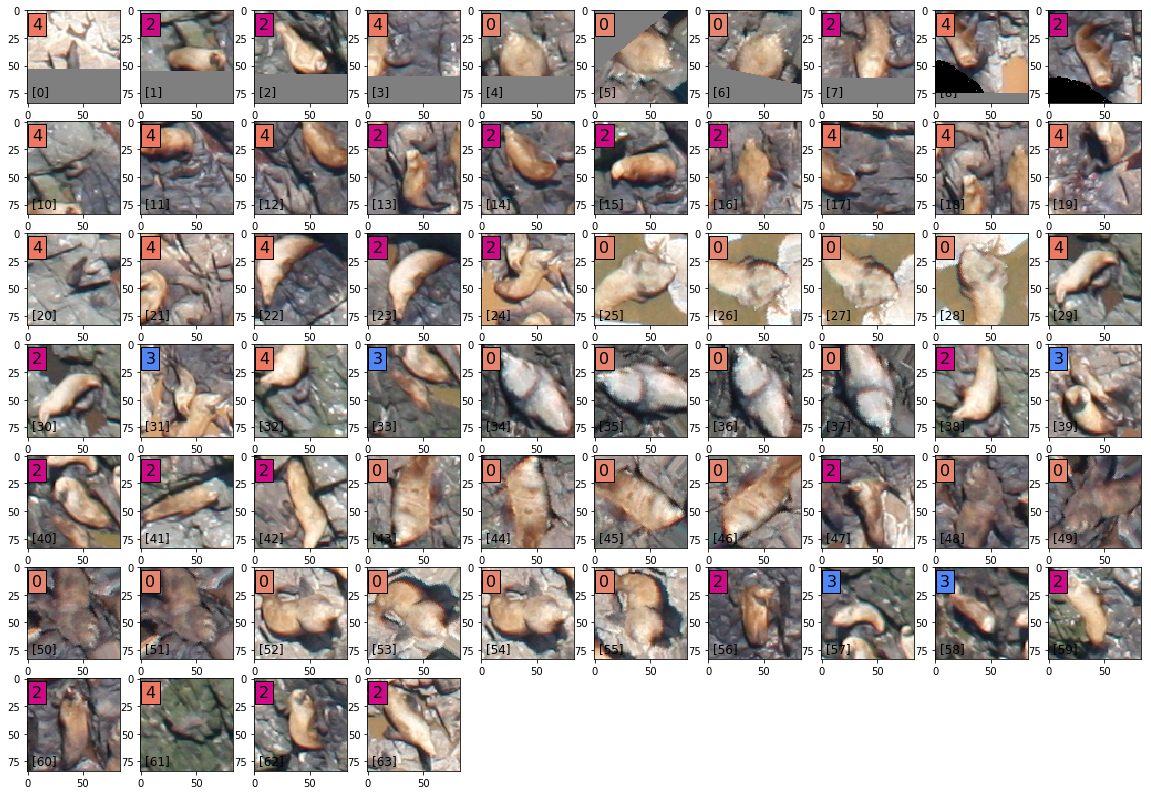

2017-04-23 20:13:16,715 INFO > [done]    generating image patches. rows=7; cols=10 (6005.011 ms)


In [6]:
#logger.info('INPUT DATASET DATA')
#dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
#with h5py.File(input_dataset_path, 'r') as h5file:
#    logger.info('generator')
#    input_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0.001, end_ratio=0.0012, batch_size=64)
#    X, Y = utils.dump_xy_to_array(input_generator.flow(), input_generator.size, x=True, y=True)
#    utils.show_images(X, image_labels=utils.onehot_to_label(Y), group_by_label=False, cols=10, is_bgr=True, size=2)
#
#    logger.info('x ' + str(np.shape(X)))
#    logger.info('y ' + str(np.shape(Y)))
#    logger.info(str(utils.class_distribution(Y)))

logger.info('BALANCE GENERATOR DATA')
dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
X_train, Y_train = utils.dump_xy_to_array(train_generator, train_balance_generator.size, x=False, y=True)
logger.info('y ' + str(np.shape(Y_train)))
logger.info(str(utils.class_distribution(Y_train)))

for xs,ys in train_balance_generator.flow():
    utils.show_images(xs, image_labels=utils.onehot_to_label(ys), cols=10, is_bgr=True, size=2)
    break

### Prepare CNN model

In [4]:
logger.info('Load CNN model')
#model = lions.convnet_alexnet2_lion_keras(IMAGE_DIMS)

model = None
if(LOAD_MODEL_FILE!=None and os.path.isfile(LOAD_MODEL_FILE)):
    with open(LOAD_MODEL_FILE, 'r') as model_file:
        my = model_file.read()
        model = models.model_from_yaml(my)
        logger.info('loaded model from file ' + LOAD_MODEL_FILE)

else:
    model = lions.convnet_simple_lion_keras(IMAGE_DIMS)
        logger.info('loaded model from function')
    
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

if(LOAD_WEIGHTS_FILE!=None and os.path.isfile(LOAD_WEIGHTS_FILE)):
    logger.info('Loading previous weights...')
    model.load_weights(LOAD_WEIGHTS_FILE)

logger.info('Model prepared')

2017-04-23 20:06:55,483 INFO Load CNN model
2017-04-23 20:06:55,593 INFO Model prepared


## Train model

In [7]:
if(RUN_TRAINING):
    logger.info('Starting CNN training...')
    history = model.fit_generator(train_generator,
                  steps_per_epoch = train_balance_generator.nr_batches,
                  nb_epoch = TRAIN_EPOCHS,
                  callbacks = cnn.get_callbacks_keras(model, WEIGHTS_DIR, TF_LOGS_DIR),
                  validation_data = valid_balance_generator.flow(), 
                  validation_steps = valid_balance_generator.nr_batches,
                  verbose = 1)

    if(SAVE_MODEL_FILE!=None):
        with open(SAVE_MODEL_FILE, 'w') as model_file:
            model_file.write(model.to_yaml())
            logger.info('Saved last model to ' + SAVE_MODEL_FILE)
    
    if(SAVE_WEIGHTS_FILE!=None):
        model.save_weights(SAVE_WEIGHTS_FILE)
        logger.info('Saved last weights to ' + SAVE_WEIGHTS_FILE)


### Epoch accuracy/loss

In [8]:
if(RUN_TRAINING):
    logger.info('Training info')
    cnn.show_training_info_keras(history)

### Confusion matrix

2017-04-23 20:13:16,745 INFO Evaluating model performance (21070 samples)...
2017-04-23 20:13:16,747 INFO starting new flow...
2017-04-23 20:13:37,627 INFO Accuracy: 0.155208333333 - Loss: 1.79150954593
2017-04-23 20:13:37,628 INFO Predicting Y for detailed analysis...
/notebooks/datascience-snippets/kaggle-sea-lion/modules/cnn.py:65: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if(self.y_ds==None):
2017-04-23 20:13:58,384 INFO Number of test samples: 21070
2017-04-23 20:13:58,400 INFO Kappa score: -0.00868421187393 (-1 bad; 0 just luck; 1 great)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2017-04-23 20:13:58,405 INFO 
                 precision    recall  f1-score   support

   0-adult_male       0.00      0.00      0.00      3404


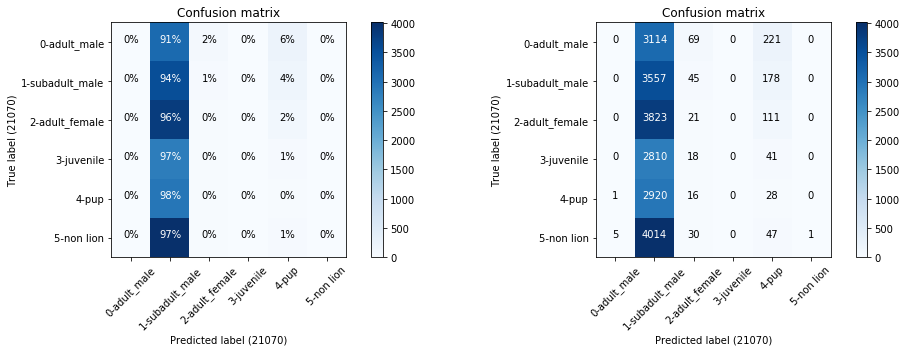

In [9]:
cnn.evaluate_dataset_keras(test_balance_generator.flow(), 
                       test_balance_generator.nr_batches, 
                       test_balance_generator.size, 
                       model, 
                       class_labels=lions.CLASS_LABELS)

2017-04-23 20:13:59,111 INFO > [started] generator dump...
2017-04-23 20:13:59,112 INFO starting new flow...


64/50

2017-04-23 20:13:59,182 INFO > [done]    generator dump (71.069 ms)
2017-04-23 20:13:59,261 INFO showing 50 images
2017-04-23 20:13:59,263 INFO > [started] generating image patches. rows=5; cols=12...


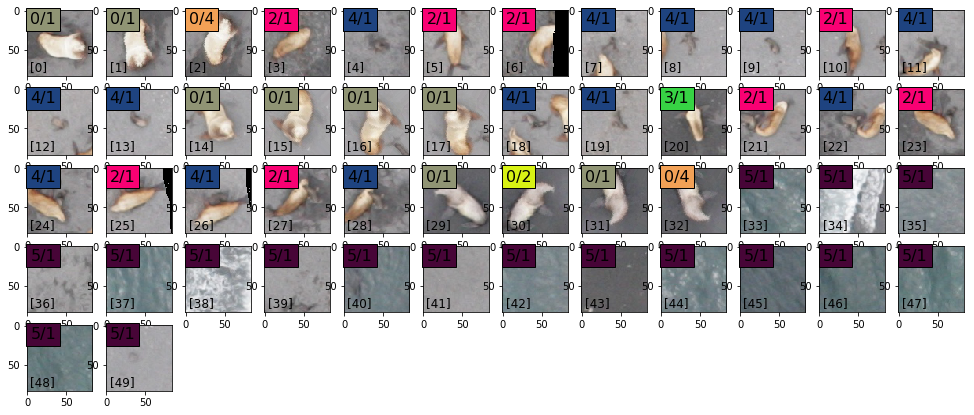

2017-04-23 20:14:03,814 INFO > [done]    generating image patches. rows=5; cols=12 (4550.959 ms)


In [10]:
a = test_balance_generator.flow()
cnn.show_predictions(a, 50, model)